In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torchnet
import torchvision.models as models
import torchvision.transforms as transforms
from munch import Munch
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

import dataset

In [2]:
# pytorch 0.2 and torchvision 0.1.9
import sys
import torchvision
assert sys.version.startswith('2')
assert torch.__version__.startswith('0.2')
assert '0.1.9' in torchvision.__file__

In [3]:
# pretrained alexnet
config_path = 'pretrained/alexnet/config.yml'
epoch = 45

# pretrained vgg16
#config_path = 'pretrained/vgg16/config.yml'
#epoch = 12

# pretrained inception_v3
#config_path = 'pretrained/inception_v3/config.yml'
#epoch = 7

# pretrained resnet152
#config_path = 'pretrained/resnet152/config.yml'
#epoch = 5

# pretrained resnet152_3class
#config_path = 'pretrained/resnet152_3class/config.yml'
#epoch = 5

In [4]:
#config_path = 'logs/your_log_dir/config.yml'
#epoch = your_best_epoch

In [5]:
with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

In [6]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))

print("=> creating model '{}'".format(cfg.arch.model))
model = models.__dict__[cfg.arch.model](pretrained=cfg.arch.pretrained)

if cfg.arch.model.startswith('alexnet') or cfg.arch.model.startswith('vgg'):
    model.classifier._modules['6'] = nn.Linear(4096, cfg.arch.num_classes)
elif cfg.arch.model == 'inception_v3':
    model.aux_logits = False
    model.fc = nn.Linear(2048, cfg.arch.num_classes)
elif cfg.arch.model == 'resnet152':
    model.fc = nn.Linear(2048, cfg.arch.num_classes)
else:
    raise Exception

if cfg.arch.model.startswith('alexnet') or cfg.arch.model.startswith('vgg'):
    model.features = torch.nn.DataParallel(model.features)
    model.cuda()
else:
    model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True

=> creating model 'alexnet'


In [7]:
resume_path = cfg.training.resume.replace(cfg.training.resume[-16:-8], '{:08}'.format(epoch))
if os.path.isfile(resume_path):
    print("=> loading checkpoint '{}'".format(resume_path))
    checkpoint = torch.load(resume_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print("=> loaded checkpoint '{}' (epoch {})".format(resume_path, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_path))
    print('')
    raise Exception

=> loading checkpoint 'pretrained/alexnet/checkpoint_00000045.pth.tar'
=> loaded checkpoint 'pretrained/alexnet/checkpoint_00000045.pth.tar' (epoch 45)


In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
val_transforms = []
if cfg.arch.model == 'inception_v3':
    val_transforms.append(transforms.Scale(299))
val_dataset = dataset.DDSM(cfg.data.root, 'val', transforms.Compose(val_transforms + [
    transforms.ToTensor(),
    normalize,
]))
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=cfg.data.batch_size, shuffle=False,
    num_workers=cfg.data.workers, pin_memory=True)

In [9]:
targets = [[] for _ in xrange(cfg.arch.num_classes)]
probs = [[] for _ in xrange(cfg.arch.num_classes)]
aucs = [torchnet.meter.AUCMeter() for _ in xrange(cfg.arch.num_classes)]

for input, target in tqdm(val_loader):
    input_var = Variable(input, volatile=True)
    output = model(input_var)
    prob = nn.Softmax()(output)
    for i in xrange(cfg.arch.num_classes):
        aucs[i].add(prob[:, i].data, target == i)
        targets[i].extend(target.numpy() == i)
        probs[i].extend(prob[:, i].data.cpu().numpy())

for i in xrange(cfg.arch.num_classes):
    print('class {}'.format(i))
    print('torchnet.meter.AUCMeter: {}'.format(aucs[i].value()[0]))
    print('sklearn.metrics.roc_auc_score: {}'.format(roc_auc_score(targets[i], probs[i])))
    print('')

HBox(children=(IntProgress(value=0, max=1395), HTML(value=u'')))


class 0
torchnet.meter.AUCMeter: 0.863248339575
sklearn.metrics.roc_auc_score: 0.86324838266

class 1
torchnet.meter.AUCMeter: 0.863248425744
sklearn.metrics.roc_auc_score: 0.863248436516



In [10]:
def plot_roc_curve(y_true, y_score):
    plt.figure(figsize=(8, 8))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.gca().set_aspect('equal')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, color='black')
    plt.show()

class 0


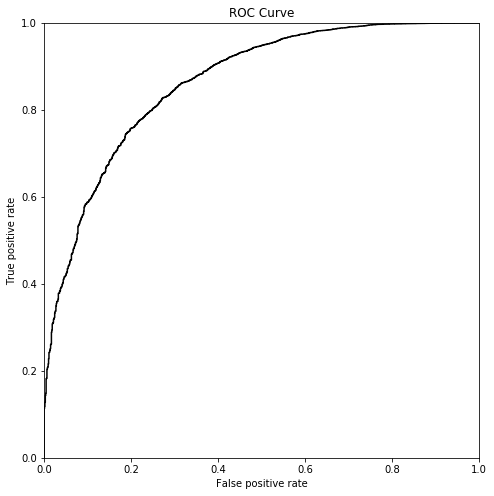

class 1


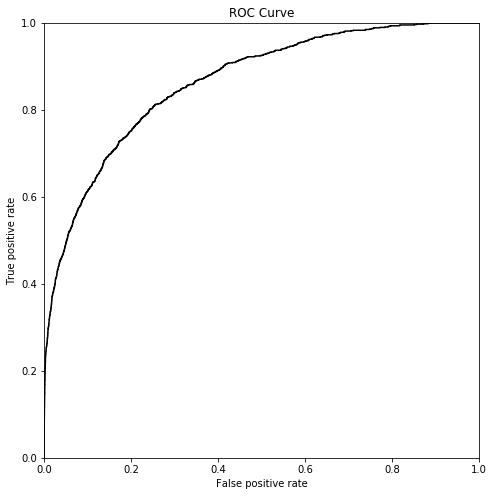

In [11]:
for i in xrange(cfg.arch.num_classes):
    print('class {}'.format(i))
    plot_roc_curve(targets[i], probs[i])